In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from prophet import Prophet
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import time
import numpy as np
# from sqlalchemy import create_engine
# from sqlalchemy.engine import URL
# import psycopg2

# from config import db_password


In [2]:
# read results df
file = 'Outputs/Prophet_Daily_Model.csv'
df = pd.read_csv(file,parse_dates=['ds'])
df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,SecuritiesCode,Fact
0,2017-01-04,2585.747593,1567.296422,3231.166765,2585.747593,2585.747593,-206.849676,-206.849676,-206.849676,-604.458765,...,902.820911,-505.211821,-505.211821,-505.211821,0.0,0.0,0.0,2378.897918,1301,2742.0
1,2017-01-05,2587.050455,1529.739375,3084.500438,2587.050455,2587.050455,-249.105524,-249.105524,-249.105524,-604.458765,...,852.528009,-497.174768,-497.174768,-497.174768,0.0,0.0,0.0,2337.944931,1301,2738.0
2,2017-01-06,2588.353316,1578.232421,3227.348454,2588.353316,2588.353316,-200.240823,-200.240823,-200.240823,-604.458765,...,885.188660,-480.970718,-480.970718,-480.970718,0.0,0.0,0.0,2388.112493,1301,2740.0
3,2017-01-07,2589.656177,-1323.535815,251.940187,2589.656177,2589.656177,-3121.782141,-3121.782141,-3121.782141,-604.458765,...,-2060.478291,-456.845085,-456.845085,-456.845085,0.0,0.0,0.0,-532.125964,1301,0.0
4,2017-01-08,2590.959039,-1303.870322,319.283427,2590.959039,2590.959039,-3090.541567,-3090.541567,-3090.541567,-604.458765,...,-2060.863206,-425.219596,-425.219596,-425.219596,0.0,0.0,0.0,-499.582529,1301,0.0


In [3]:
df_clean = df[df['yhat'] >= 0]
df_clean = df_clean.dropna()
df_securities = df_clean[['SecuritiesCode','ds','yhat']]
df_securities.head(5)

,SecuritiesCode,ds,yhat
0,1301,2017-01-04,2378.897918
1,1301,2017-01-05,2337.944931
2,1301,2017-01-06,2388.112493
5,1301,2017-01-09,2198.934919
6,1301,2017-01-10,2530.105773


In [4]:
# getting close prices for all SecuritiesCodes
#prices = df.pivot(index='Date', columns='SecuritiesCode', values='Close')
close_prices = df_clean[['SecuritiesCode','ds','yhat']]
close_prices['Target'] = close_prices['yhat']
prices_target = close_prices.pivot(index='ds', columns='SecuritiesCode', values='Target')
prices_target = prices_target.dropna()
prices_target.head()

SecuritiesCode,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
ds,,,,,,,,,,,,,,,,,,,,,
2020-12-24,2620.406675,439.978506,2164.764185,1534.098805,1331.750387,3167.453214,1777.727576,2647.994344,2941.955525,1827.782102,...,1617.787442,65389.998220,6237.382022,3429.120884,3622.504689,631.607184,877.476283,1500.907448,2027.274161,853.681858
2020-12-25,2600.760041,435.817888,2142.800024,1623.977718,1324.206146,3148.388634,1768.330958,2641.813517,2992.639257,1813.364697,...,1606.784284,65631.527770,6223.548263,3401.909778,3598.785136,617.672485,867.540486,1492.843474,2024.379964,848.821280
2020-12-29,2411.803152,399.190127,1962.483387,1460.291738,1226.788819,2907.060762,1639.261384,2428.624912,2894.815027,1669.061469,...,1477.867509,61231.815941,5761.721292,3088.360183,3369.131376,553.864218,797.774719,1386.145560,1882.107364,788.443152
2020-12-30,2395.602175,396.567882,1945.326400,1529.487939,1219.452616,2896.155972,1633.956765,2425.764433,2919.312230,1656.375300,...,1473.064388,61467.637712,5732.313085,3079.070294,3341.393717,542.303075,789.059390,1379.990845,1871.752696,780.095274
2020-12-31,2315.338548,381.344165,1871.993405,1400.229133,1181.190828,2802.224196,1579.684800,2332.564133,2842.271444,1581.993757,...,1421.288815,59553.050737,5497.664113,2964.083169,3244.230832,519.146835,760.920098,1336.684790,1810.469076,750.017648


In [5]:
# first 200 values of SecuritiesCodes for every time step(1202).
first_200 = []
for i in range(0,len(prices_target.index),1):
      first_200.append(-np.sort(-prices_target.iloc[i, :].values)[:200])
prices_target_first_200 = pd.DataFrame(first_200,index=prices_target.index)
prices_target_first_200.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
ds,,,,,,,,,,,,,,,,,,,,,
2020-12-24,65389.998220,52441.777324,51349.738266,47965.515067,44896.525927,29734.781141,25887.038686,22533.226873,20317.786614,20082.466702,...,4608.350426,4603.308509,4600.508682,4597.986854,4595.089820,4557.222911,4522.385621,4522.369020,4514.076078,4497.705628
2020-12-25,65631.527770,53016.941562,51488.688990,48010.974597,45211.780804,30016.937479,25878.187869,23879.348967,20234.965543,20176.661657,...,4620.398014,4617.522474,4613.210188,4612.847597,4609.491904,4584.571328,4582.170784,4577.141471,4557.167010,4549.215191
2020-12-29,61231.815941,49183.444664,48322.680446,45017.878775,42831.894147,28558.299361,24394.993304,23064.382641,18987.335649,18910.707491,...,4264.904094,4252.270518,4244.393471,4242.906468,4206.361148,4198.227734,4183.383114,4176.345643,4148.534340,4130.348691
2020-12-30,61467.637712,50195.708414,48463.754846,45053.156079,42952.562084,28689.839436,24529.495071,24384.102089,19042.703521,18839.253867,...,4274.740342,4270.579733,4258.565324,4236.909599,4215.856323,4183.253586,4169.977515,4136.400408,4133.284001,4109.820905
2020-12-31,59553.050737,47314.490703,47056.573706,43709.292877,41681.307484,27981.159195,23697.903119,20299.426250,18490.775220,18219.920094,...,4130.516332,4125.215955,4109.379994,4094.413152,4074.150154,4058.780369,4002.847978,3983.192452,3970.620891,3960.579842


In [6]:
# last 200 values of SecuritiesCodes for every time step(1202).
last_200 = []
for i in range(0,len(prices_target.index),1):
      last_200.append(np.sort(prices_target.iloc[i, :].values)[0:200])
prices_target_last_200 = pd.DataFrame(last_200,index=prices_target.index)
prices_target_last_200.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
ds,,,,,,,,,,,,,,,,,,,,,
2020-12-24,43.183438,49.401148,61.808919,62.497296,75.842850,84.398568,89.523834,121.896549,132.229287,165.272412,...,562.846633,563.810881,567.819583,569.016810,569.230525,571.691366,573.393038,575.489452,579.782644,580.430076
2020-12-25,44.565819,48.452285,59.942218,61.906571,74.148343,75.785976,89.231416,120.581559,131.352073,156.824385,...,560.496128,561.428389,563.321240,564.286866,565.276546,567.952269,568.983537,572.960844,573.030860,573.903052
2020-12-29,42.427273,44.792672,54.599333,55.153353,57.224748,71.153740,77.556996,111.940854,121.538682,148.436457,...,516.473362,517.355575,517.464285,517.899105,519.787833,520.029785,523.146202,523.210754,524.018599,526.890520
2020-12-30,43.027802,44.092745,51.260844,53.724456,56.961853,71.000214,81.202439,111.163215,120.627341,145.721014,...,510.598743,512.859198,512.994232,513.525112,514.389827,516.113044,517.471720,520.297668,520.551095,524.288868
2020-12-31,41.485411,42.416069,43.842687,51.954925,55.042150,68.613946,83.185348,107.637075,114.812768,116.186692,...,489.447820,491.385077,493.090305,494.378799,494.679577,495.501839,495.808384,496.316197,500.230486,500.580380


In [7]:
weights = np.linspace(start=2, stop=1, num=200)
weights

array([2.        , 1.99497487, 1.98994975, 1.98492462, 1.9798995 ,
       1.97487437, 1.96984925, 1.96482412, 1.95979899, 1.95477387,
       1.94974874, 1.94472362, 1.93969849, 1.93467337, 1.92964824,
       1.92462312, 1.91959799, 1.91457286, 1.90954774, 1.90452261,
       1.89949749, 1.89447236, 1.88944724, 1.88442211, 1.87939698,
       1.87437186, 1.86934673, 1.86432161, 1.85929648, 1.85427136,
       1.84924623, 1.84422111, 1.83919598, 1.83417085, 1.82914573,
       1.8241206 , 1.81909548, 1.81407035, 1.80904523, 1.8040201 ,
       1.79899497, 1.79396985, 1.78894472, 1.7839196 , 1.77889447,
       1.77386935, 1.76884422, 1.7638191 , 1.75879397, 1.75376884,
       1.74874372, 1.74371859, 1.73869347, 1.73366834, 1.72864322,
       1.72361809, 1.71859296, 1.71356784, 1.70854271, 1.70351759,
       1.69849246, 1.69346734, 1.68844221, 1.68341709, 1.67839196,
       1.67336683, 1.66834171, 1.66331658, 1.65829146, 1.65326633,
       1.64824121, 1.64321608, 1.63819095, 1.63316583, 1.62814

In [8]:
Sup=((prices_target_first_200 * weights).sum(axis = 1))/np.mean(weights)
Sup

ds
2020-12-24    1.908696e+06
2020-12-25    1.918361e+06
2020-12-29    1.793353e+06
2020-12-30    1.800933e+06
2020-12-31    1.735507e+06
                  ...     
2021-11-23    2.228981e+06
2021-11-24    2.259427e+06
2021-11-25    2.219258e+06
2021-11-26    2.264402e+06
2021-11-29    2.127999e+06
Length: 231, dtype: float64

In [9]:
Sdown=((prices_target_last_200 * weights).sum(axis = 1))/np.mean(weights)
Sdown

ds
2020-12-24    73388.601151
2020-12-25    72570.771015
2020-12-29    66697.382447
2020-12-30    65909.336295
2020-12-31    63204.626426
                  ...     
2021-11-23    88044.053888
2021-11-24    88802.405641
2021-11-25    87382.948896
2021-11-26    88726.953894
2021-11-29    79750.616239
Length: 231, dtype: float64

In [10]:
(Sup - Sdown)

ds
2020-12-24    1.835307e+06
2020-12-25    1.845790e+06
2020-12-29    1.726655e+06
2020-12-30    1.735024e+06
2020-12-31    1.672302e+06
                  ...     
2021-11-23    2.140937e+06
2021-11-24    2.170625e+06
2021-11-25    2.131875e+06
2021-11-26    2.175675e+06
2021-11-29    2.048249e+06
Length: 231, dtype: float64

In [11]:
daily_spread_return = (Sup - Sdown).mean()/(Sup - Sdown).std()
daily_spread_return

14.827901366910849

In [12]:
count_SecuritiesCode_first_200 = prices_target.isin(prices_target_first_200.values.flatten())
True_first_200 = (count_SecuritiesCode_first_200.apply(pd.Series.value_counts, axis=0).fillna(0).iloc[1:2]).T
True_first_200 = True_first_200.add_prefix('first_200_')

In [13]:
count_SecuritiesCode_last_200 = prices_target.isin(prices_target_last_200.values.flatten())
True_last_200 = (count_SecuritiesCode_last_200.apply(pd.Series.value_counts, axis=0).fillna(0).iloc[1:2]).T
True_last_200 = True_last_200.add_prefix('last_200_')

In [14]:
Count = pd.concat([True_first_200,True_last_200],axis=1)
Count

,first_200_True,last_200_True
SecuritiesCode,,
1301,0.0,0.0
1332,0.0,231.0
1333,0.0,0.0
1375,0.0,0.0
1376,0.0,0.0
...,...,...
9990,0.0,160.0
9991,0.0,0.0
9993,0.0,0.0


In [15]:
SecuritiesCode_weight = (Count/len(prices_target.index)).sum(axis=1)/2

In [16]:
df_weight = pd.DataFrame(SecuritiesCode_weight,columns=["Weight"]).reset_index()

In [17]:
df_weight

,SecuritiesCode,Weight
0,1301,0.00000
1,1332,0.50000
2,1333,0.00000
3,1375,0.00000
4,1376,0.00000
...,...,...
1995,9990,0.34632
1996,9991,0.00000
1997,9993,0.00000
1998,9994,0.00000


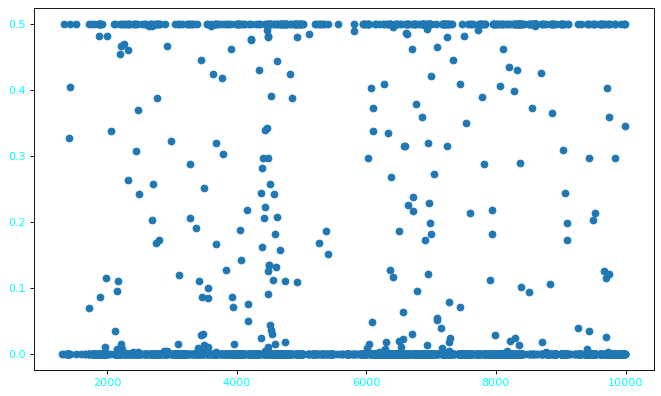

In [27]:
plt.figure(figsize=(10, 6), dpi=80)
plt.xticks(color='cyan')
plt.yticks(color='cyan')
plt.scatter(x=SecuritiesCode_weight.index,y=SecuritiesCode_weight)

In [44]:
Count.reset_index
Count.columns
top_ranked = Count.sort_values(by=['first_200_True'],ascending=False).iloc[0:200]

In [45]:
top_ranked = top_ranked.drop(columns='last_200_True',axis=1)
top_ranked

,first_200_True
SecuritiesCode,
6201,231.0
4051,231.0
6806,231.0
3914,231.0
2413,231.0
...,...
2702,119.0
3496,116.0
4369,113.0


In [47]:
top_ranked.to_csv('Outputs/top_ranked.csv')

In [ ]:
df_securities['daily_return'] = (df_securities.sort_values(by=['SecuritiesCode','ds'])
                                 .groupby('SecuritiesCode')['yhat'].pct_change())

In [ ]:
df_securities['rank'] = (df_securities.sort_values(by=['ds'])
                                 .groupby('ds')['daily_return'].rank(method='max',ascending=False))

In [ ]:
df_securities.head()

In [ ]:
df_securities = df_securities.dropna()
df_securities.head()

In [ ]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['rank'].min() == 0
        assert df['rank'].max() == len(df['rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('ds').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [ ]:
calc_spread_return_sharpe(df_securities, 200, 2)

In [ ]:
df_securities = df_securities.drop(columns=['avg_rank'], axis=1)
df_securities

In [ ]:
df_securities = df_securities.drop(columns = ['avg_rank'], index=1)

In [ ]:
df_securities['avg_rank'] = (df_securities#.sort_values(by=['ds','rank'])
                                 .groupby('ds')['rank'].mean())
df_securities.head()

In [ ]:
df_securities['avg_rank'].unique()